In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [29]:
df = pd.read_csv('malicious_phish.csv')

In [30]:
df.shape

(651191, 2)

In [31]:
df.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


/Users/syamprakash/opt/miniconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


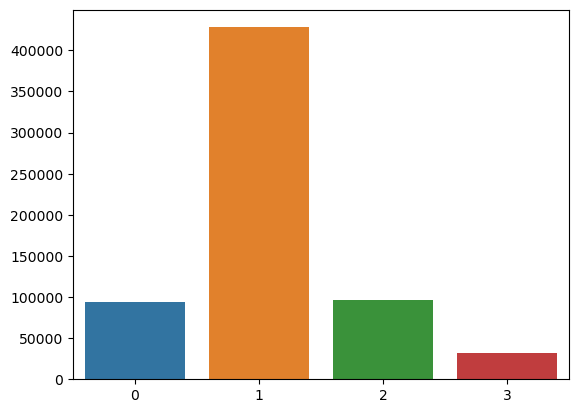

In [124]:
sns.barplot(df['type'].value_counts().index,df['type'].value_counts().values)
plt.show()

We do not have enough features for prediction. So let's create new features from the existing DNS we have. 

In [36]:
df['dns_length'] = df['url'].str.len()
df['dns_dot'] = df['url'].str.count('\.')
df['dns_hyphen'] = df['url'].str.count('\-')
df['dns_numbers'] = df['url'].str.count('[0-9]')
df['dns_numbers_percentage'] = df['url'].str.count('[0-9]')/df['url'].str.len()
df['slash_count'] = df['url'].str.count('\/')

In [37]:
def last_dns(dns):
    last_dns = dns.split('.')[-1]
    return last_dns
df['last_dns'] = df['url'].apply(last_dns)

In [38]:
import re
def word_count(dns):
    word_dns = len(re.split('\W+', dns))
    return word_dns
df['dns_word_count'] = df['url'].apply(word_count)

In [39]:
df.head()

,url,type,dns_length,dns_dot,dns_hyphen,dns_numbers,dns_numbers_percentage,slash_count,last_dns,dns_word_count
0,br-icloud.com.br,phishing,16,2,1,0,0.000000,0,br,4
1,mp3raid.com/music/krizz_kaliko.html,benign,35,2,0,1,0.028571,2,html,5
2,bopsecrets.org/rexroth/cr/1.htm,benign,31,2,0,1,0.032258,3,htm,6
3,http://www.garage-pirenne.be/index.php?option=...,defacement,88,3,1,7,0.079545,3,php?option=com_content&view=article&id=70&vsig...,15
4,http://adventure-nicaragua.net/index.php?optio...,defacement,235,2,1,22,0.093617,3,php?option=com_mailto&tmpl=component&link=aHR0...,12


In [40]:
def has_ip(link):
    if re.match('\d+\.\d+\.\d+\.\d+', link):
        return 1
    else :
        return 0 

In [41]:
df['has_ip'] = df['url'].apply(has_ip)

In [42]:
def vowel_percentage(s):
    vowel = s.count('a') + s.count('e')+s.count('i')+s.count('o')+s.count('u')/len(s)
    return vowel

In [43]:
df['vowel_percentage'] = df['url'].apply(vowel_percentage)

In [44]:
df.head()

,url,type,dns_length,dns_dot,dns_hyphen,dns_numbers,dns_numbers_percentage,slash_count,last_dns,dns_word_count,has_ip,vowel_percentage
0,br-icloud.com.br,phishing,16,2,1,0,0.000000,0,br,4,0,3.062500
1,mp3raid.com/music/krizz_kaliko.html,benign,35,2,0,1,0.028571,2,html,5,0,8.028571
2,bopsecrets.org/rexroth/cr/1.htm,benign,31,2,0,1,0.032258,3,htm,6,0,6.000000
3,http://www.garage-pirenne.be/index.php?option=...,defacement,88,3,1,7,0.079545,3,php?option=com_content&view=article&id=70&vsig...,15,0,22.000000
4,http://adventure-nicaragua.net/index.php?optio...,defacement,235,2,1,22,0.093617,3,php?option=com_mailto&tmpl=component&link=aHR0...,12,0,27.025532


In [45]:
# counting non-alphanumeric characters in the URL 
df['dns_non_alphanumeric_percentage'] = df['url'].str.count('[^a-zA-Z\d\s:]')/df['url'].str.len()

In [46]:
df.type.unique()

array(['phishing', 'benign', 'defacement', 'malware'], dtype=object)

In [47]:
mapping = {'phishing':0, 'benign':1, 'defacement' : 2, 'malware' : 3}
df['type'] = df['type'].map(mapping)

In [48]:
df.drop(['url', 'last_dns'], axis=1, inplace = True)

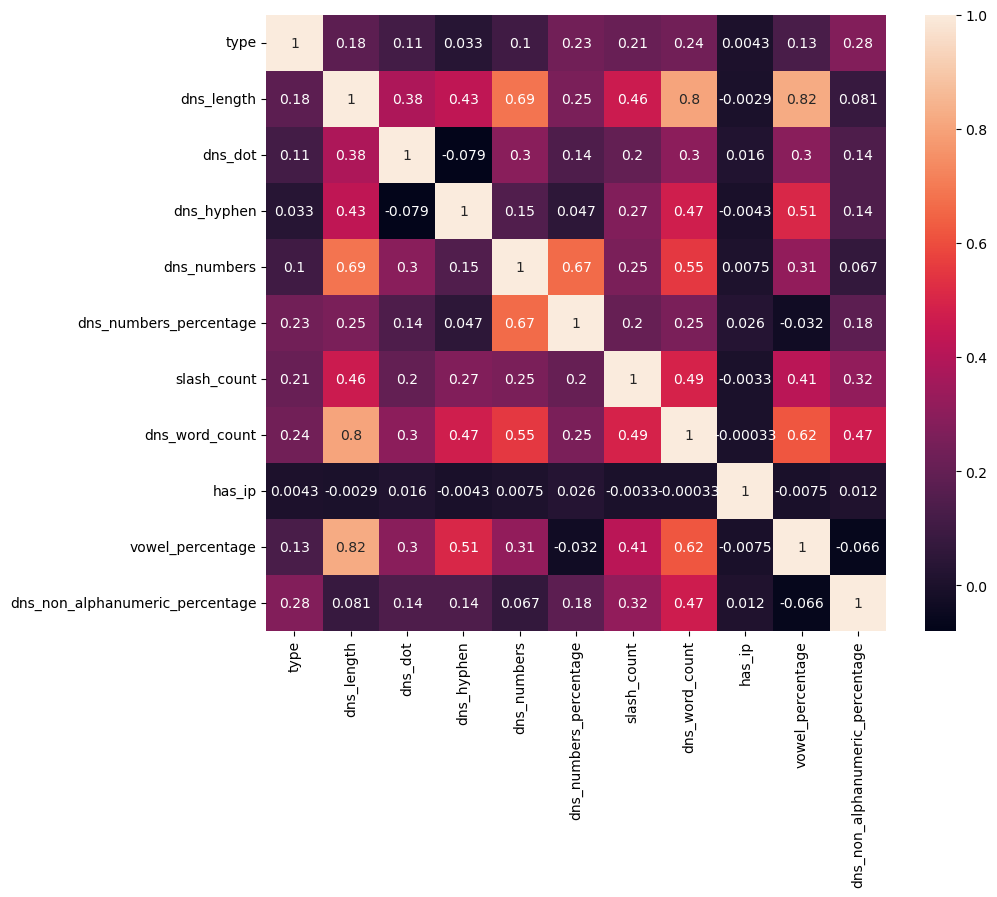

In [49]:
correlation_df = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_df, annot=True)
plt.show()


In [76]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

X = df.loc[:, df.columns!='type']
y = df['type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [77]:
DT = DecisionTreeClassifier()
DT.fit(X_train, y_train)

DecisionTreeClassifier()

In [78]:
pd.DataFrame(list(zip(DT.feature_names_in_,DT.feature_importances_)), columns=['Feature names', 'Coef Importance']).sort_values(by = 'Coef Importance', ascending=False)

,Feature names,Coef Importance
5,slash_count,0.234309
1,dns_dot,0.172615
8,vowel_percentage,0.159482
4,dns_numbers_percentage,0.107743
6,dns_word_count,0.099617
0,dns_length,0.076235
9,dns_non_alphanumeric_percentage,0.075820
2,dns_hyphen,0.049100
3,dns_numbers,0.025030
7,has_ip,0.000051


In [89]:
# y_test = y_test.array.reshape(-1,1)
y_pred = DT.predict(X_test)
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

DT_accuracy_score  = accuracy_score(y_test, y_pred)
DT_f1_score = f1_score(y_test, y_pred, average = None)
print('F1 Score : ', DT_f1_score)
print('accuracy score : ', DT_accuracy_score)

F1 Score :  [0.71117311 0.93789586 0.90457263 0.91866177]
accuracy score :  0.8991441353822214


In [90]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [91]:
y_pred = rf.predict(X_test)

rf_accuracy_score  = accuracy_score(y_test, y_pred)
rf_f1_score = f1_score(y_test, y_pred, average = None)
print('F1 Score : ', rf_f1_score)
print('accuracy score : ', rf_accuracy_score)

F1 Score :  [0.74233324 0.94972063 0.92746542 0.93874531]
accuracy score :  0.9175104167733085


In [92]:
pd.DataFrame(list(zip(rf.feature_names_in_,rf.feature_importances_)), columns=['Feature names', 'Coef Importance']).sort_values(by = 'Coef Importance', ascending=False)

,Feature names,Coef Importance
5,slash_count,0.204588
8,vowel_percentage,0.155641
1,dns_dot,0.144965
6,dns_word_count,0.110788
9,dns_non_alphanumeric_percentage,0.104389
0,dns_length,0.090103
4,dns_numbers_percentage,0.088792
3,dns_numbers,0.051153
2,dns_hyphen,0.049555
7,has_ip,0.000027
